# Bayesian Neural Networks with Variational Inference

We have revisted the general concept of variational inference (VI) and one application to linear regression in this <a href="">post</a>. We will quickly review the basic concepts needed to understand the following.

In contrast to maximum likelihood, which assumes one true parameter set $\hat{\boldsymbol{\theta}}$ that best explains our data, the Bayesian approach imposes a prior distribution onto the parameters and thereby treating them as random variables. A comparison for the simplest case of linear regression can be found <a href="https://maltetoelle.github.io/linear/regression/2020/10/27/try.html">here</a>. For a data set $\mathcal{D}=(\mathbf{x}_i,\mathbf{y}_i)$ Bayes theorem is given by

$$p(\boldsymbol{\theta}|\mathcal{D})=\frac{p(\mathcal{D}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{p(\mathcal{D})}=\frac{p(\mathcal{D}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{\int p(\mathcal{D}|\boldsymbol{\theta})p(\boldsymbol{\theta})\,d\boldsymbol{\theta}}~,$$

where the posterior of our model parameters $p(\boldsymbol{\theta}|\mathcal{D})$ is obtained by multiplying the likelihood $p(\mathcal{D}|\boldsymbol{\theta})$, the probability for seeing this data with our model parameters, with the prior $p(\boldsymbol{\theta})$, our assumption for the parameter distribution of the parameters before seeing any data. This can also be an uniform (non-informative) prior, assigning the same probability to all parameter distributions. To obtain a valid probability distribution the product of the two must be normalized to integrate to one, which is done by dividing by the evidence $p(\mathcal{D})$ that is obtained by marginalizing out all possible parameter distributions. Even for simple models that are non-linear this calculation becomes intractable. So we must help ourselves with approximation frameworks such as variational inference or Markov Chain Monte Carlo (MCMC) sampling, which was compared to linear regression with variational inference in the same <a href="">post</a>.

The predictive distribution for a new data point $(\mathbf{x}_*,\mathbf{y}_*$ is in the Bayesian framework obtained by marginalizing out the posterior parameter distribution

$$p(\mathbf{y}_*|\mathbf{x}_*,\mathcal{D})=\int p(\mathbf{y}_*|\mathbf{x}_*,\mathcal{D},\boldsymbol{\theta})p(\boldsymbol{\theta}|\mathcal{D})\,d\boldsymbol{\theta}~.$$

In VI we use a simpler distribution $q(\boldsymbol{\theta})$ to approximate our intractable posterior. The optimization objective is then given by the minimum of the KL divergence between approsimate and true posterior

$$F(q):=\mathrm{KL}(q(\boldsymbol{\theta})||p(\boldsymbol{\theta}|\mathcal{D}))=\int q(\boldsymbol{\theta})\log \frac{q(\boldsymbol{\theta})}{p(\boldsymbol{\theta}|\mathcal{D})}\,\mathrm{d}\boldsymbol{\theta} \longrightarrow \underset{q(\boldsymbol{\theta}) \in \mathcal{Q}}{\min} ~.$$

Although it is not a true distance measure because of its asymmetry, it can be seen as one, as it has its minimum of zero, if and only if both distributions are equal. For all other distributions it is always greater than zero. Befor we dive deeper into the derivations for applying VI to neural networks, we will quick revisit the important properties of the KL divergence, because they come in handy later.

## KL Divergence

The KL divergence is defined as

$$
\begin{align}
\mathrm{KL}(q(x)||p(x)) &= \textrm{H}(q(x),p(x)) - \textrm{H}(q(x)) \\
&= - \int q(x) \log p(x)\,dx - \left( - \int q(x)\log q(x)\,dx \right) \\
&= \int q(x)\log\frac{q(x)}{p(x)}\,dx~,
\end{align}
$$

where $\textrm{H}(q(x),p(x))$ denotes the cross-entropy between $q$ and $p$ and $\textrm{H}(q(x))$ is the entropy of $q$. Formally, the KL divergence measures, how much information is lost, when p is approximated by q or vice versa. For two Gaussian distributions the KL divergence can be computed analytically

$$
\begin{aligned}
\mathrm{KL}(q(x)||p(x)) &= \int q(x)\log q(x)\,dx - \int q(x)\log p(x)\,dx\\
&= \frac{1}{2}\log\left(2\pi\sigma_p^2\right) + \frac{\sigma_q^2 + \left( \mu_q - \mu_p \right)^2}{2\sigma_p^2} - \frac{1}{2}\left( 1 + \log\left(2\pi\sigma_q^2\right) \right)\\
&= \log\frac{\sigma_p}{\sigma_q} + \frac{\sigma_q^2 + \left( \mu_q - \mu_p \right)^2}{2\sigma_p^2} - \frac{1}{2} ~.
\end{aligned}
$$

For more complicated distributions, where the KL divergence is not analytically tractable, but the expectation can be approximated using Monte Carlo (MC) samples:

$$
\mathrm{KL}(q(x)||p(x)) = \mathbb{E}_{x\sim q}\left[ \log\frac{q(x)}{p(x)} \right] \approx \sum_{i=0}^{N}\left( \log q(x_i) - \log p(x_i) \right)~.
$$

An example for a more complicated distribution is the mixture of two Gaussians, a bimodal Gaussian:

$$p(x)=\sum_i \pi_i \mathcal{N}(x|\mu_i,\sigma_i)~.$$

The important properties of the KL divergence are:

$$
\begin{aligned}
    \textrm{non-negativity}&: \quad \mathrm{KL}(q(x)||p(x)) \geq 0 ~, \;\; \forall x ~,\\
    \textrm{equality}&: \quad \mathrm{KL}(q(x)||p(x)) = 0 \quad \textrm{if and only if} \quad q(x) = p(x) ~,\\
   \textrm{asymmetry}&: \quad \mathrm{KL}(q(x)||p(x)) \neq \mathrm{KL}(p(x)||q(x)) ~.
\end{aligned}
$$

The KL divergence becomes zero, if and only if both distributions are equal. For all other distributions is is always greater than zero. As already said it is not a true distance metric becaus of its asymmetry. We distinguish between the reverse (exclusive) $\mathrm{KL}(q(x)||p(x))$ and the forward (inclusive) $\mathrm{KL}(p(x)||q(x))$ case. The following illustrates both cases.

In [3]:
import torch
from torch.distributions.distribution import Distribution
from torch.distributions.normal import Normal

def mc_kl_divergence(p: Distribution, q: Distribution, n_samples: int = 1) -> torch.Tensor:
    kl = 0
    for _ in range(n_samples):
        sample = p.rsample()
        kl += p.log_prob(sample) - q.log_prob(sample)
    return kl / n_samples

class MixtureNormal(Distribution):
    def __init__(self, loc, scale, pi):
        super(MixtureNormal, self).__init__()
        
        assert(len(loc) == len(pi))
        assert(len(scale) == len(pi))

        self.loc = torch.tensor(loc)
        self.scale = torch.tensor(scale)
        self.pi = torch.tensor(pi)

        self.dists = [Normal(loc, scale) for loc, scale in zip(self.loc, self.scale)]

    def rsample(self) -> torch.Tensor:
        x = torch.rand(1)
        rsample = 0
        for pi, dist in zip(self.pi, self.dists):
            rsample += pi * torch.exp(dist.log_prob(dist.cdf(x)))
        return rsample

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        pdf = 0
        for pi, dist in zip(self.pi, self.dists):
            pdf += pi.to(x.device) * torch.exp(dist.log_prob(x))
        return torch.log(pdf)

In [4]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm

def optimize_kl(p: Distribution, intial_mu_q: float = 0., intial_sigma_q: float = 1., kl_type: str = 'forward', 
                num_iter: int = 100, n_samples: int = 100) -> (float, float):
    
    # intial values for mu_q and sigma_q
    mu_q = torch.tensor([intial_mu_q], requires_grad=True)
    sigma_q = torch.tensor([intial_sigma_q], requires_grad=True)
    optim = torch.optim.Adam([mu_q, sigma_q])
    for i in tqdm(range(num_iter)):
        optim.zero_grad()
        q = Normal(mu_q, sigma_q)
        if kl_type == 'forward':
            loss = mc_kl_divergence(q, p, n_samples=n_samples)
        else:
            loss = mc_kl_divergence(p, q, n_samples=n_samples)
        loss.backward()
        optim.step()
    return mu_q.item(), sigma_q.item()

100%|██████████| 1000/1000 [00:34<00:00, 29.09it/s]


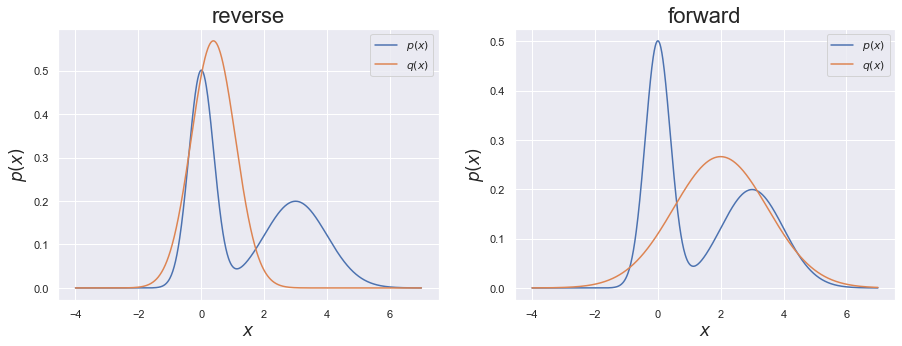

In [3]:
mu1, mu2, sigma1, sigma2 = 0, 3, 0.4, 1.
x = torch.linspace(-4, 7, 1000)

p = MixtureNormal(loc=[mu1, mu2], scale=[sigma1, sigma2], pi=[0.5, 0.5])

fig, axs = plt.subplots(1, 2, figsize=(15,5))
for i, kl_type in enumerate(['reverse', 'forward']):
    mu_q, sigma_q = optimize_kl(p, intial_mu_q=1.5, intial_sigma_q=2., kl_type=kl_type, num_iter=1000, n_samples=50)
    q = Normal(mu_q, sigma_q)
    
    axs[i].plot(x, p.log_prob(x).exp(), label=r'$p(x)$')
    axs[i].plot(x, q.log_prob(x).exp(), label=r'$q(x)$')
    axs[i].set_xlabel(r'$x$', fontsize=17)
    axs[i].set_ylabel(r'$p(x)$', fontsize=17)
    axs[i].set_title(kl_type, fontsize=22)
    axs[i].legend()

plt.show()

To better understand the two behaviours we brake down the KL divergence piece by piece. As can be seen in the reverse case the KL divergence approximates the mode of the $p$ and thereby leaving a lot of mass uncovered. As we would like to minimize the KL divergence we must minimize the $\log\frac{q}{p}$ term, which is small in areas, where $p$ is large. Thereby the objective converges to a mode of $p$. In the forward case on the other hand the objective gets small in areas, where $p$ is small, since it weighs our $\log$ term.

## (Log) Evidence Lower Bound

One can rewrite the log evidence such that we are left with the KL divergence from above and another term, named the (log) evidence lower bound or short ELBO

$$
\begin{aligned}
\log p(\mathcal{D}) &= \int q(\boldsymbol{\theta})\log\frac{p(\mathcal{D},\boldsymbol{\theta})}{q(\boldsymbol{\theta})}\,d\boldsymbol{\theta} + \int q(\boldsymbol{\theta})\frac{q(\boldsymbol{\theta})}{p(\boldsymbol{\theta}|\mathcal{D})}\,d\boldsymbol{\theta} \\
&= \textrm{ELBO}(q(\boldsymbol{\theta})) + \mathrm{KL}(q(\boldsymbol{\theta})||p(\boldsymbol{\theta}|\mathcal{D})) \\
&\geq \textrm{ELBO}(q(\boldsymbol{\theta})) ~.
\end{aligned}
$$

As the KL divergence is always greater than zero, maximizing the first term, the ELBO, w.r.t. $q$ is essentially equal to minimizing the second term, the KL divergence.



When applying the ELBO as optimization criterion to neural networks it must further be simplified into a data-dependent likelihood term and a regularizer measuring the "distance" between prior and posterior.

$$
\begin{aligned}
\textrm{ELBO}(q(\boldsymbol{\theta})) &= \int q(\boldsymbol{\theta}) \log \frac{p(\mathcal{D}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{q(\boldsymbol{\theta})}\,d\boldsymbol{\theta}  \\
&= \int q(\boldsymbol{\theta}) \log p(\mathcal{D}|\boldsymbol{\theta})\,d\boldsymbol{\theta} + \int q(\boldsymbol{\theta})\log\frac{p(\boldsymbol{\theta})}{q(\boldsymbol{\theta})}\,d\boldsymbol{\theta} \\
&= \underbrace{\mathbb{E}_{\boldsymbol{\theta}\sim q} \log p(\mathcal{D}|\boldsymbol{\theta})}_{\textrm{likelihood term}} - \underbrace{\mathrm{KL}(q(\boldsymbol{\theta})||p(\boldsymbol{\theta}))}_{\textrm{regularizer}}
\end{aligned}
$$

In each optimization step we sample weights $\boldsymbol{\theta}$ from our approximate posterior $q(\boldsymbol{\theta})$. The expectation of the likelihood term then measures how well on average our model fits the data. The KL divergence measures how well our approximate posterior matches our prior. Since it must be minimized in order to minimize the ELBO, the model tries to keep the posterior as close as possible to the prior. For computing the above KL divergence we can now either use the forward or reverse version.

Now, the question remains to which family of distributions $\mathcal{Q}$ to restrict $q$ to allow for tractable soluitons for approximating the true posterior. We can either use a parametric distribution $q_{\boldsymbol{\omega}}(\boldsymbol{\theta})$ governed by a set of parameters $\boldsymbol{\omega}$. Hence, the ELBO becomes a function of $\boldsymbol{\omega}$, and we can exploit standard non-linear optimization techniques to determine the optimal values for the parameters. Another possibility is to use factorized distributions. We will revisit both concepts in the domain of neural networks and apply them to the case of non-linear regression.

## Mean Field Assumption

As was the case in the linear regression example we start by using a factorized distribution as approximation, known as mean field approximation

$$q(\boldsymbol{\theta})=\prod_i q_i(\boldsymbol{\theta}_i)~,$$

which discards covariances in the parameters because of the factorization, but leads to faster computation time as this decreases the number of parameters to optimize as well. To model each individual $q_i(\boldsymbol{\theta}_i)$ we will use a Gaussian distribution $\mathcal{N}(\boldsymbol{\theta}_i|\boldsymbol{\mu}_i,\boldsymbol{\sigma}_i)$ as this is justified under the Bayesian central limit theorem. As can be seen in the comparison of MCMC sampling and VI for linear this assumption usually leads to an underestimation of the variance in the parameters.

When we want to apply the mean field approximation to a neural network a problem arises, when we want to apply the backpropagation algorithm to a probability distribution. The general update formula of gradient descent, which lies at the heart of backpropagation, is given by

$$\theta_{ij}^* = \theta_{ij} - \eta \frac{\partial\mathcal{L}(\boldsymbol{\theta})}{\partial\theta_{ij}}~,$$

where the new value $\theta_{ij}^*$ for each weight after every iteration is obtained by subtracting the partial derivate of some loss function $\mathcal{L}(\boldsymbol{\theta})$ (e.g. mean squared error, cross-entropy) w.r.t. that particualr weight $\theta_{ij}$ weighted by a learning rate $\eta$ from $\theta_{ij}$. The above formula can only be applied to point estimates of the parameters only, each weight must have one explicitly defined value. Following from that, it is not applicable to probability distributions in their standard form.

### (Local) Reparametrization Trick

Remedy comes in the form of the reparametrization trick, which separates the deterministic and stochastic components of the weights (Kingma and Welling 2013, Blundell et al. 2015). Instead of sampling weights directly from $q(\boldsymbol{\theta})$ the mean and the variance of the Gaussians modelling the weights are treated as parameters and another random variable $\boldsymbol{\epsilon}$ is introduced:

$$
\begin{gathered}
\theta_{ij} \sim \mathcal{N}(\mu_{ij},\sigma_{ij}) ~,\\
\theta_{ij} = \mu_{ij} + \sigma_{ij}\epsilon_{ij} \quad \textrm{with} \quad \epsilon_{ij} \sim \mathcal{N}(0,1) ~.
\end{gathered}
$$

In each forward pass the weights are sampled according to the formula above and then, subsequently, the partial derivate to mean and variance is computed. This essentially means the number of parameters is doubled. To ensure an always positive variance, the reparametrization is usually extended with the Sodtplus function:

$$\theta_{ij}=\mu_{ij} + \log\left( 1+ \exp\left(\sigma_{ij}^2\right) \right)\epsilon_{ij}~.$$

The following images explain the above, the difference the reparametrization makes, visually. One the left the initial situation is presented, where each weight $\theta$ is modelled with a distribution $q$. On the right the reparametrization trick is shown, in which in each forward pass the weight is sampled.

<div>
    <img src="usual-1.png" width=300>
    <img src="rt-1.png" width=300>
</div>

The reparametrization trick described above still exhibits limitations concerning the variance. If we were to sample one weight for each mini-batch, the resulting outputs would show high covariances. We could circumvent this problem by sampling a separate weight for each mini-batch, but this is computational expensive. Kingma et al. (2015) first discovered that for a factorized Gaussian posterior on the weights, the posterior on the activations is also a factorized Gaussian. Thus, instead of sampling the weights directly we can also sample from the pre-activation neuron. Kingma et al. (2015) report much lower variance and computational time for their gradient estimator termed local reparametrization trick. We will conduct a comparison later, when we have implemented both. More formally, their reparametrization trick is mathematically given by

$$
\begin{gathered}
q_{\omega}(\theta_{ij})=\mathcal{N}(\mu_{ij},\sigma_{ij}^{2}) \;\; \forall \;\; \theta_{ij} \in \boldsymbol{\theta} \quad \Longrightarrow \quad q_{\omega}(b_{mj}|\mathbf{A})=\mathcal{N}(\gamma_{mj},\delta_{mj}) ~,\\
\gamma_{mj}=\sum_{i} a_{mi}\mu_{ij} ~,\\
\delta_{mj}=\sum_{i} a_{mi}^{2}\sigma_{ij}^{2} ~,\\
b_{mj}=\gamma_{mj}+\sqrt{\delta_{mj}}\epsilon_{mj}\quad\textrm{with}\quad \epsilon_{mj} \sim \mathcal{N}(0,1) ~,
\end{gathered}
$$

where $\boldsymbol{\epsilon}$ is a matrix of the same size as $\mathbf{B}$. The difference between the two reparametrization tricks is visualized in the following.

<div>
    <img src="rt-1.png" width=300>
    <img src="lrt-1.png" width=300>
</div>

### Implementation

#### General VI Module

To later be able to extend the concept to the local reparametrization trick, we start by implementing a general VI module, which lies at the heart of all further layers.

In [29]:
from typing import Callable
from torch.nn import Parameter, Module
from torch.nn.functional import softplus
from torch.distributions.kl import kl_divergence

class VIModule(Module):

    def __init__(self,
                 layer_fct: Callable,
                 weight_size: tuple,
                 bias_size: tuple = None,
                 prior: dict = None,
                 posteriors: dict = None,
                 kl_type: str = 'reverse'):

        super(VIModule, self).__init__()
        
        # function for forward pass e.g. F.linear, F.conv2d
        self.layer_fct = layer_fct
        
        # fall back to default vals
        if prior is None:
            prior = {'mu': 0, 'sigma': 0.1}

        if posteriors is None:
            posteriors = {
                'mu': (0, 0.1),
                'rho': (-3., 0.1)
            }
        
        # if prior is ScaleMixture we must use MC integration for KL div.
        # otherwise we can compute KL div. analitically
        if 'pi' in list(prior.keys()):
            self._kl_divergence = mc_kl_divergence
            self.prior = MixtureNormal(prior['mu'], prior['sigma'], prior['pi'])
        else:
            self._kl_divergence = kl_divergence
            self.prior = Normal(prior['mu'], prior['sigma'])
        
        # either 'forward' or 'reverse'
        self.kl_type = kl_type
        
        # save parameters for resetting
        self.posterior_mu_initial = posteriors['mu']
        self.posterior_rho_initial = posteriors['rho']
        
        # initialize weights and biases
        self.W_mu = Parameter(torch.empty(weight_size))
        self.W_rho = Parameter(torch.empty(weight_size))
        if bias_size is not None:
            self.bias_mu = Parameter(torch.empty(bias_size))
            self.bias_rho = Parameter(torch.empty(bias_size))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)
        
        # reset
        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

        if self.bias_mu is not None:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)
    
    @property
    def kl(self):
        # compute KL div. by instantiating the weights as Normal distribution
        _kl = self.kl_divergence(Normal(self.W_mu.cpu(), softplus(self.W_rho).cpu()), self.prior, self.kl_type).sum()
        if self.bias_mu is not None:
            _kl += self.kl_divergence(Normal(self.bias_mu.cpu(), softplus(self.bias_rho).cpu()), self.prior, self.kl_type).sum()
        return _kl

    def kl_divergence(self, p: Distribution, q: Distribution, kl_type: str = 'reverse') -> torch.Tensor:
        # either reverse or forward KL div.
        if kl_type == 'reverse':
            return self._kl_divergence(q, p)
        else:
            return self._kl_divergence(p, q)

    @staticmethod
    def rsample(mu: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
        # reparametrization trick
        eps = torch.empty(mu.size()).normal_(0, 1).to(mu.device)
        return mu + eps * sigma

In this post we will be using linear layers only, but the module can easily be extended to a convolutional layer by changing the layer function. The VI module can be given a prior as well as a posterior distribution. Dependend on wether a mixture of Gaussians shall be used as prior, the KL divergence is either computed analytically with the version provided by PyTorch or our MC Kl divergence is used. Further we can specify, wether the forward or reverse KL divergence shall be computed. At last, it implements a function for performing reparametrization.

#### (Local) Reparametrization Trick Layer

Now we extend our VI module with the reparametrization trick and its local counterpart.

In [30]:
class RTLayer(VIModule):

    def __init__(self,
                 layer_fct: Callable,
                 weight_size: tuple,
                 bias_size: tuple = None,
                 prior: dict = None,
                 posteriors: dict = None,
                 kl_type: str = 'reverse',
                 **kwargs):

        super(RTLayer, self).__init__(layer_fct=layer_fct,
                                      weight_size=weight_size,
                                      bias_size=bias_size,
                                      prior=prior,
                                      posteriors=posteriors,
                                      kl_type=kl_type)
        # these will be used for an easy extension to a convolutional layer
        self.kwargs = kwargs

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # sample each weight with reparametrization trick
        weight = self.rsample(self.W_mu, softplus(self.W_rho))
        if self.bias_mu is not None:
            bias = self.rsample(self.bias_mu, softplus(self.bias_rho))
        else:
            bias = None
        # use this weight for forward pass
        return self.layer_fct(x, weight, bias, **self.kwargs)

    
class LRTLayer(VIModule):

    def __init__(self,
                 layer_fct: Callable,
                 weight_size: tuple,
                 bias_size: tuple = None,
                 prior: dict = None,
                 posteriors: dict = None,
                 kl_type: str = 'reverse',
                 **kwargs):

        super(LRTLayer, self).__init__(layer_fct=layer_fct,
                                       weight_size=weight_size,
                                       bias_size=bias_size,
                                       prior=prior,
                                       posteriors=posteriors,
                                       kl_type=kl_type)
        # these will be used for an easy extension to a convolutional layer
        self.kwargs = kwargs

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # first conduct forward pass for mean and variance
        act_mu = self.layer_fct(x, self.W_mu, self.bias_mu, **self.kwargs)
        self.W_sigma = softplus(self.W_rho)
        if self.bias_mu is not None:
            bias_var = softplus(self.bias_rho) ** 2
        else:
            bias_var = None
        act_std = torch.sqrt(1e-16 + self.layer_fct(x**2, self.W_sigma**2, bias_var, **self.kwargs))
        # sample from activation
        return self.rsample(act_mu, act_std)

The implementation for both the "normal" reparametrization layer (RTLayer) and the local reparametrization layer (LRTLayer) look both very similar. The only difference can be spotted in the forward function. As described earlier the RTLayer first samples the weight vector and then performs the forward pass. In contrast to that the LRTLayer first performs the forward pass for mean and variance and afterwards uses the reparametrization trick to sample from these activations.

#### Linear Layer

The extensions to real layers, linear and convolutional, is trivial now. The example for a linear layer can be found underneath, the implementation for the convolutional layers can be found at the end of the post.

In [31]:
from torch.nn.functional import linear

class LinearRT(RTLayer):

    def __init__(self,
                 in_features: int,
                 out_features: int,
                 bias: bool = True,
                 prior: dict = None,
                 posteriors: dict = None,
                 kl_type: str = 'reverse'):

        self.in_features = in_features
        self.out_featurs = out_features

        weight_size = (out_features, in_features)

        bias_size = (out_features) if bias else None

        super(LinearRT, self).__init__(layer_fct=linear,
                                        weight_size=weight_size,
                                        bias_size=bias_size,
                                        prior=prior,
                                        posteriors=posteriors,
                                        kl_type=kl_type)

class LinearLRT(LRTLayer):

    def __init__(self,
                 in_features: int,
                 out_features: int,
                 bias: bool = True,
                 prior: dict = None,
                 posteriors: dict = None,
                 kl_type: str = 'reverse'):

        self.in_features = in_features
        self.out_featurs = out_features

        weight_size = (out_features, in_features)

        bias_size = (out_features) if bias else None

        super(LinearLRT, self).__init__(layer_fct=linear,
                                        weight_size=weight_size,
                                        bias_size=bias_size,
                                        prior=prior,
                                        posteriors=posteriors,
                                        kl_type=kl_type)

#### Loss Function

Before we can start using these layers in a neural network, we must implement our loss function, the ELBO. As a loss function we use the full negative log likelihood. This has the advantage of being able to estimate the full uncertainty. We will not dive deeper into the derivations, this is done in another <a href="">post</a>. As a quick overview, uncertainty can be divided into uncertainty or noise inherent in the data, called aleatoric uncertainty, and uncertainty inherent in our model, termed epistemic uncertainty. The aleatoric uncertainty is captured implictly during training with our loss function and can also be estimated without employing Bayesian techniques. To capture epistemic uncertainty on the other hand we must impose distributions onto our parameters and follow the Bayesian approach.

To capture the aleatoric uncertainty our model $\mathbf{f}_{\boldsymbol{\theta}}$ gains a new head

$$
\mathbf{f}_{\boldsymbol{\theta}}(\mathbf{x})=\left[ \hat{\mathbf{y}},\hat{\boldsymbol{\sigma}}^2 \right]
$$

and our loss function is then given by

$$
\mathcal{L}(\boldsymbol{\theta}) = \frac{1}{D}\sum_i \frac{1}{2}\hat{\sigma}_i^2 \left( y_i - \hat{y}_i \right)^2 + \frac{1}{2}\log\hat{\sigma}_i^2 ~.
$$

Using this loss function we can implicitly learn the aleatoric uncertainty in our data (Kendall et al. 2017). For numerical stability in practice we let our model ouput the (negative) log variance as this allows for negative values as well:

$$
\mathcal{L}(\boldsymbol{\theta}) = \frac{1}{D}\sum_i\frac{1}{2}\exp \left( -\log \hat{\sigma}_i^2 \right) \left( y_i - \hat{y}_i \right)^2 - \frac{1}{2}\log\hat{\sigma}_i^2 ~.
$$

In Regression $D$ is set to the number of samples in the mini-batch, while in classification $D=1$. To also account for epistemic uncertainty we need to compute the variance of the output using Monte Carlo integration

$$
\mathrm{Var}\left[\mathbf{y}\right]=\underbrace{\frac{1}{T}\sum_{t=1}^{T}\hat{\mathbf{y}}_t^2-\left(\frac{1}{T}\sum_{t=1}^{T}\hat{\mathbf{y}}_t \right)^2}_{\textrm{epistemic}}+\underbrace{\boldsymbol{\sigma}}_{\textrm{aleatoric}} ~,
$$

where $\boldsymbol{\sigma}$ denotes the aleatoric part estimated with the full negative log likelihood.

In [84]:
def gaussian_nll(mu: torch.Tensor, logvar: torch.Tensor, target: torch.Tensor, 
                 reduction: str = 'mean') -> torch.Tensor:
    loss = torch.exp(-logvar) * torch.pow(target - mu, 2) + logvar
    return loss.mean() if reduction=='mean' else loss.sum()

class ELBO(Module):
    def __init__(self, train_size: int = 1, train_type: str = 'regression'):        
        super(ELBO, self).__init__()
        self.train_size = train_size
        self.reduction = 'mean' if train_type == 'regression' else 'sum'

    def forward(self, inputs: torch.Tensor, target: torch.Tensor, kl: torch.Tensor, 
                beta: float = 1.) -> torch.Tensor:
        return gaussian_nll(inputs[:,0], inputs[:,1], target[:,0], self.reduction) * self.train_size + beta * kl

def calc_uncert(preds: [torch.Tensor], reduction: str = 'mean') -> (torch.Tensor, torch.Tensor, torch.Tensor):
    preds = torch.cat(preds, dim=0)
    epi = torch.var(preds[:,:,0], dim=0)
    ale = torch.mean(preds[:,:,1], dim=0)#.exp()
    uncert = ale + epi
    if reduction == 'mean':
        return ale.mean(), epi.mean(), uncert.mean()
    else:
        return ale, epi, uncert

#### KL Divergence Reweighting

The attentive reader may have noticed that we have reweighted both our likelihood as well as our KL divergence in the above code for the ELBO. A problem in training Bayesian neural networks with VI arises when we have a discrepancy between number of model parameters and data set size. Most often our number of parameters exceed the number of training points leading to overfitting when performing maximum likelihood estimation. When utilizing the ELBO this means the magnitude of the KL divergence term, the regularizer, exceeds the likelihood cost and the training focusses on reducing the complexity instead of the likelihood. Thus, the KL divergence term must be reweighted by a factor $\beta$:

$$
\textrm{ELBO}(q(\boldsymbol{\theta})) = \mathbb{E}_{\boldsymbol{\theta}\sim q} \log p(\mathcal{D}|\boldsymbol{\theta}) - \beta \mathrm{KL}(q(\boldsymbol{\theta})||p(\boldsymbol{\theta})) ~.
$$

A good value for $\beta$ leads to an initial magnitude of the complexity cost comparable to the magnitude of the likelihood term. But considering only the likelihood disregards the number of model parameters, which highly influences the magnitude of the KL divergence. Following from this, the KL divergence must be scaled by the number of parameters to ensure its magnitude is only influenced by the approximation between posterior and prior. Reducing the number of parameters would otherwise decrease the complexity cost without increasing the model fit. At best, the likelihood is scaled by the number of data points in the data set to balance out both terms. 

Since the use for the ELBO is motivated by enabling mini-batched training, the literature provides different $\beta$ for training with mini-batches. The standard scaling factor was introduced by Graves (2011), which sets $\beta=\frac{1}{M}$, where $M$ denotes the number of mini-batches. A more sophisticated version is provided by Blundell et al. (2015): 

$$\beta_i = \frac{2^{M-i}}{2^M-1} ~, \quad i \in \{1,...,M\} ~,$$

where $i$ denotes the number of the current batch number. This condition ensures that $\beta$ is not uniform across mini-batches but still sophisticates $\sum_{i=1}^M \beta_i=1$. While assuming higher values for $\beta$ at the beginning of training, the importance of the complexity costrapidly declines. By utilizing this approach the prior gets more influential in the beginning,before the training focuses on the likelihood, when more data is observed.

In [33]:
from typing import Union

def get_beta(beta_type: Union[float, str] = 1., batch_idx: int = 1, m: int = 1, 
             epoch: int = 1, num_epochs: int = 1) -> float:
    if beta_type == "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    elif beta_type == "Standard":
        beta = 1 / m
    else:
        beta = beta_type
    return beta

Before we conduct experiments with the above described VI framework, we will revisit another very popular technique for approximate variational inference in neural networks that gains its popularity from its simplicity and fewer computational requirements.

## Monte Carlo Dropout

Coming from the rather intuitive way of modelling each weight with a Gaussian distribution to incorporate uncertainty into the model parameters, Monte Carlo (MC) dropout is less instinctive but bears some strong advantages. Gal and Ghahramani (2016) proposed dropout as approximate Bayesian inference. Their idea is basically simple, instead of just applying dropout during training to prevent overfitting dropout is also applied during testing. This makes the output of the model a random variable to and we are able to quantify uncertainty is described earlier.

The derivation relies on variational inference and is based on some heavy assumptions about the prior. For the full proof the interested reader is referred to Gal and Ghahramani (2015).

An MC dropout layer is easy implemented in PyTorch.

In [34]:
from torch.nn.functional import dropout

class MCDropout(Module):
    def __init__(self, p: float):
        super(MCDropout, self).__init__()
        self.p = p
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return dropout(x, self.p, training=True)

### Experiments

define model

#### Non-Linear Regression

generate data

#### Gradient Comparison

#### Different $\beta$

#### Reverse Forward KL

#### Uncertainties

In [161]:
from torch.nn.functional import relu
from torch.nn import Sequential, Linear

class Model(Module):
    
    def __init__(self, in_features: int = 1, out_features: int = 2, inf_type: str = 'vi_lrt', 
                 prior: dict = None, posteriors: dict = None, p: float = 0.5):
        
        super(Model, self).__init__()
        
        if inf_type == 'vi_lrt':
            layer = lambda in_features, out_features : LinearLRT(in_features=in_features, 
                                                                 out_features=out_features, 
                                                                 prior=prior, 
                                                                 posteriors=posteriors)
            self._kl = 'vi'
        elif inf_type == 'vi_rt':
            layer = lambda in_features, out_features : LinearRT(in_features=in_features, 
                                                                out_features=out_features, 
                                                                prior=prior, 
                                                                posteriors=posteriors)
            self._kl = 'vi'
        elif inf_type == 'dropout':
            layer = lambda in_features, out_features : Sequential(Linear(in_features=in_features, 
                                                                         out_features=out_features), 
                                                                         MCDropout(p=p))
            self._kl = None # lambda: torch.tensor([0])
        else:
            layer = lambda in_features, out_features : Linear(in_features=in_features, 
                                                              out_features=out_features)
            self._kl = None # lambda: torch.tensor([0])
        
        self.layer1 = layer(in_features, 20)
        self.layer2 = layer(20, 20)
        self.layer3 = layer(20, out_features)
        
        self.inf_type = inf_type
    
    def forward(self, x: torch.Tensor) -> (torch.Tensor, torch.Tensor):
        x = relu(self.layer1(x))
        x = relu(self.layer2(x))
        x = self.layer3(x)
        return x, self.kl_div()
    
    def kl_div(self) -> torch.Tensor:
        if self._kl is None:
            return torch.tensor([0])
        else:
            return torch.tensor([module.kl for module in self.children()]).sum()
    
    def gradients(self) -> float:
        return torch.cat([param.grad.flatten() for param in self.parameters()]).sum().item()

In [182]:
from torch.optim import Optimizer, Adam

def train(model: Module, loss_fct: Callable, x: torch.Tensor, y: torch.Tensor, 
          batch_size: int = 1, beta_type: Union[float, str] = 1., optim: Optimizer = Adam,
          weight_decay: float = 0., lr: float = 1e-3, num_epochs: int = 1000) -> (list, list, list):

    losses, kls, grads = [], [], []
    
    optim = optim(model.parameters(), lr=lr, weight_decay=weight_decay)
    m = int(len(x)/batch_size)
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        idx = torch.randperm(len(x))
        #_x = x[random_idx[:m * batch_size]]
        #_y = y[random_idx[:m * batch_size]]
        total_loss, total_kl = 0, 0
        for batch_idx in range(1, m+1):
            optim.zero_grad()
            
            out, kl = model(x[idx[(batch_idx-1) * batch_size : batch_idx * batch_size]])

            beta = get_beta(beta_type=beta_type, batch_idx=batch_idx, m=m, epoch=epoch, num_epochs=num_epochs)
            loss = loss_fct(out, y[idx[(batch_idx-1) * batch_size : batch_idx * batch_size]], kl, beta)

            loss.backward()
            optim.step()
            
            total_loss += loss.item()
            total_kl += kl.item()
        
        losses.append(total_loss)
        kls.append(total_kl)
        grads.append(model.gradients())

        pbar.set_description('loss: %.6f' % loss.item())
    
    return losses, kls, grads

def pred(model: Module, x: torch.Tensor, mc_samples: int = 100) -> (torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor):
    
    y_preds = []
    
    with torch.no_grad():
        for _ in tqdm(range(mc_samples)):
            y_pred, _ = model(x)
            y_preds.append(y_pred.unsqueeze(0))
    
    y_mean = torch.cat(y_preds, dim=0)[:,:,0].mean(dim=0)
    if y_preds[0].shape[-1] > 1:
        ale, epi, uncert = calc_uncert(y_preds, reduction=None)
    else:
        ale, epi, uncert = 0., 0., 0.
    
    return y_mean, ale, epi, uncert

def plot_uncert(x_test: torch.Tensor, y_pred_mean: torch.Tensor, x_train: torch.Tensor, y_train: torch.Tensor, 
                ale: torch.Tensor, epi: torch.Tensor, uncert: torch.Tensor):
    
    plt.plot(x_test, y_pred_mean, color='#D1895C', label='Predictive mean');
    plt.scatter(x_train, y_train, color='black', label='Training data')
    plt.fill_between(x_test.flatten(), 
                     y_pred_mean + 2 * uncert, 
                     y_pred_mean - 2 * uncert, 
                     color='#6C85B6',
                     alpha=0.2, label='Total uncertainty')
    plt.fill_between(x_test.flatten(), 
                     y_pred_mean + 2 * ale,
                     y_pred_mean - 2 * ale,
                     color='#6C85B6',
                     alpha=0.3, label='Aleatoric uncertainty')
    plt.fill_between(x_test.flatten(), 
                     y_pred_mean + 2 * epi, 
                     y_pred_mean - 2 * epi, 
                     color='#6C85B6',
                     alpha=0.5, label='Epistemic uncertainty')
    plt.xlabel(r'$x$', fontsize=17)
    plt.ylabel(r'$y$', fontsize=17)
    plt.legend(loc='upper right')
    plt.show()

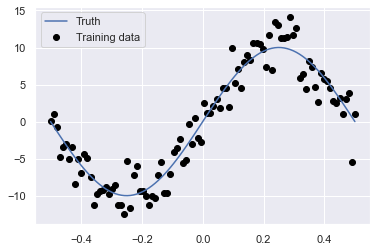

In [151]:
import numpy as np

def f(x: torch.Tensor, sigma: float) -> torch.Tensor:
    epsilon = torch.randn(*x.shape) * sigma
    return 10 * torch.sin(2 * np.pi * (x)) + epsilon

train_size = 100
sigma = 2.0

x = torch.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(x, sigma=sigma)
y_true = f(x, sigma=0.0)

plt.scatter(x, y, color='black', label='Training data')
plt.plot(x, y_true, label='Truth')
plt.legend()
plt.show()

#### Hyperparameters

In [152]:
prior = {'mu': 0, 'sigma': 0.5}

posteriors = {
    'mu': (0, 0.5),
    'rho': (-3., 0.5)
}

# no_params = lambda model: len(torch.cat([p.flatten() for p in model.parameters()]))

elbo = ELBO(train_size=len(x))
loss_fct = lambda y, out, kl, beta: elbo(y, out, kl, beta)

#beta_type = 1 / no_params(model_vi_rt)
beta_type = "Blundell"
lr = 0.05
num_epochs = 1000
batch_size = 8

In [153]:
model_vi_rt = Model(inf_type='vi_rt', prior=prior, posteriors=posteriors)
losses_rt, kls_rt, grads_rt = train(model=model_vi_rt, loss_fct=loss_fct, x=x, y=y, batch_size=batch_size, 
                           beta_type=beta_type, lr=lr, num_epochs=num_epochs)

loss: 452844.375000: 100%|██████████| 1000/1000 [00:48<00:00, 20.81it/s]


100%|██████████| 100/100 [00:00<00:00, 552.29it/s]


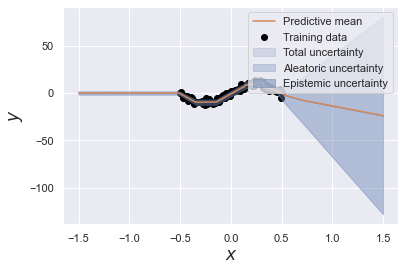

In [154]:
x_test = torch.linspace(-1.5, 1.5, 500).reshape(-1, 1)

y_pred_mean_rt, ale_rt, epi_rt, uncert_rt = pred(model=model_vi_rt, x=x_test)
plot_uncert(x_test=x_test, y_pred_mean=y_pred_mean_rt, x_train=x, y_train=y, 
                ale=ale_rt, epi=epi_rt, uncert=uncert_rt)

In [170]:
model_vi_lrt = Model(inf_type='vi_lrt', prior=prior, posteriors=posteriors)
losses_lrt, kls_lrt, grads_lrt = train(model=model_vi_lrt, loss_fct=loss_fct, x=x, y=y, batch_size=batch_size, 
                           beta_type=beta_type, lr=lr, num_epochs=num_epochs)

loss: 2.069959: 100%|██████████| 1000/1000 [00:57<00:00, 17.48it/s]


100%|██████████| 100/100 [00:00<00:00, 369.51it/s]


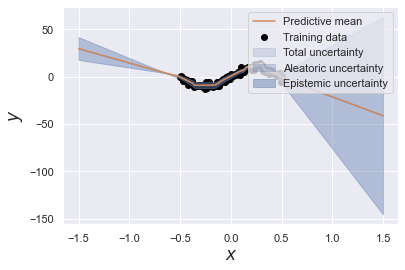

In [156]:
y_pred_mean_lrt, ale_lrt, epi_lrt, uncert_lrt = pred(model=model_vi_lrt, x=x_test)
plot_uncert(x_test=x_test, y_pred_mean=y_pred_mean_lrt, x_train=x, y_train=y, 
                ale=ale_lrt, epi=epi_lrt, uncert=uncert_lrt)

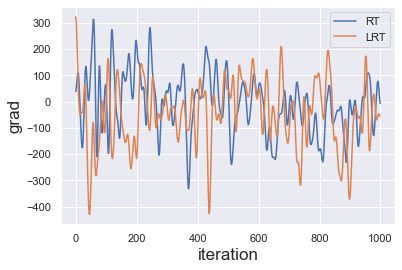

Variance RT: 501322.91
Variance LRT: 380989.91


In [157]:
from scipy.ndimage import gaussian_filter1d

plt.plot(range(len(grads_rt)), gaussian_filter1d(grads_rt, sigma=5), label=r'RT')
plt.plot(range(len(grads_lrt)), gaussian_filter1d(grads_lrt, sigma=5), label=r'LRT')
plt.legend()
plt.xlabel(r'iteration', fontsize=17)
plt.ylabel(r'grad', fontsize=17)
plt.show()

print('Variance RT: %.2f' % np.var(grads_rt))
print('Variance LRT: %.2f' % np.var(grads_lrt))

In [171]:
p = 0.01
weight_decay = 0.01

model_dropout = Model(inf_type='dropout', p=p)
loss_fct = lambda out, y, kl, beta : gaussian_nll(out[:,0], out[:,1], y[:,0], 'mean')
_, _, _ = train(model=model_dropout, loss_fct=loss_fct, x=x, y=y, batch_size=batch_size, 
                beta_type=beta_type, lr=lr, num_epochs=num_epochs, weight_decay=weight_decay)

loss: 2.390998: 100%|██████████| 1000/1000 [00:27<00:00, 36.36it/s]


100%|██████████| 100/100 [00:00<00:00, 286.01it/s]


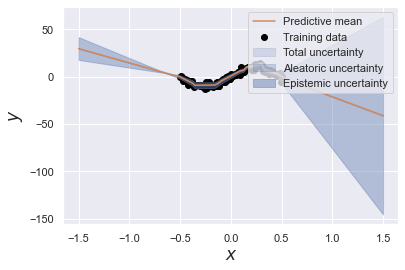

In [168]:
y_pred_mean_dropout, ale_dropout, epi_dropout, uncert_dropout = pred(model=model_vi_lrt, x=x_test)
plot_uncert(x_test=x_test, y_pred_mean=y_pred_mean_dropout, x_train=x, y_train=y, 
                ale=ale_dropout, epi=epi_dropout, uncert=uncert_dropout)

In [172]:
model_freq = Model(inf_type='freq')
loss_fct = lambda out, y, kl, beta : gaussian_nll(out[:,0], out[:,1], y[:,0], 'mean')
_, _, _ = train(model=model_freq, loss_fct=loss_fct, x=x, y=y, batch_size=batch_size, 
                beta_type=beta_type, lr=lr, num_epochs=num_epochs)

loss: 2.579343: 100%|██████████| 1000/1000 [00:22<00:00, 45.36it/s]


100%|██████████| 100/100 [00:00<00:00, 3209.16it/s]


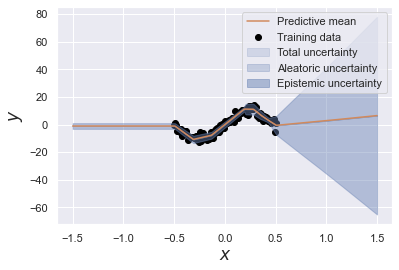

In [178]:
y_pred_mean_freq, ale_freq, epi_freq, uncert_freq = pred(model=model_freq, x=x_test)
plot_uncert(x_test=x_test, y_pred_mean=y_pred_mean_freq, x_train=x, y_train=y, 
                ale=ale_freq, epi=epi_freq, uncert=uncert_freq)

In [176]:
from torch.nn.functional import mse_loss

model_freq2 = Model(inf_type='freq', out_features=1)
loss_fct = lambda out, y, kl, beta : mse_loss(out, y)
_, _, _ = train(model=model_freq2, loss_fct=loss_fct, x=x, y=y, batch_size=batch_size, 
                beta_type=beta_type, lr=lr, num_epochs=num_epochs)

loss: 8.317492: 100%|██████████| 1000/1000 [00:18<00:00, 52.90it/s]


100%|██████████| 100/100 [00:00<00:00, 3635.56it/s]


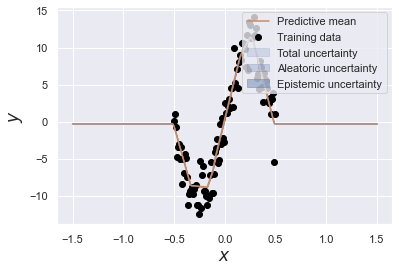

In [183]:
y_pred_mean_freq2, ale_freq2, epi_freq2, uncert_freq2 = pred(model=model_freq2, x=x_test)
plot_uncert(x_test=x_test, y_pred_mean=y_pred_mean_freq2, x_train=x, y_train=y, 
                ale=ale_freq2, epi=epi_freq2, uncert=uncert_freq2)

## Appendix

In [ ]:
from torch.nn.functional import conv2d
from torch.nn.modules.utils import _pair

class Conv2dRT(RTLayer):

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: Union[int, tuple],
                 bias: bool = True,
                 stride: int = 1,
                 padding: int = 0,
                 dilation: int = 1,
                 groups: int = 1,
                 prior: dict = None,
                 posteriors: dict = None,
                 kl_type: str = 'reverse'):

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = _pair(kernel_size)

        weight_size = (out_channels, in_channels, self.kernel_size[0], self.kernel_size[1])

        bias_size = (out_channels) if bias else None

        super(Conv2dRT, self).__init__(layer_fct=conv2d,
                                        weight_size=weight_size,
                                        bias_size=bias_size,
                                        prior=prior,
                                        posteriors=posteriors,
                                        kl_type=kl_type,
                                        stride=stride,
                                        padding=padding,
                                        dilation=dilation,
                                        groups=groups)


class Conv2dLRT(LRTLayer):

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: Union[int, tuple],
                 bias: bool = True,
                 stride: int = 1,
                 padding: int = 0,
                 dilation: int = 1,
                 groups: int = 1,
                 prior: dict = None,
                 posteriors: dict = None,
                 kl_type: str = 'reverse'):

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = _pair(kernel_size)

        weight_size = (out_channels, in_channels, self.kernel_size[0], self.kernel_size[1])

        bias_size = (out_channels) if bias else None

        super(Conv2dLRT, self).__init__(layer_fct=conv2d,
                                        weight_size=weight_size,
                                        bias_size=bias_size,
                                        prior=prior,
                                        posteriors=posteriors,
                                        kl_type=kl_type,
                                        stride=stride,
                                        padding=padding,
                                        dilation=dilation,
                                        groups=groups)